![title](../imgs/avengers_ensemble.jpg)

# Bem vindos !


<img src="../imgs/que-bom.jpg" width="600">

# Warmup & Expectations !


O que vocês esperam da aula de Hoje?

<img src="https://media.giphy.com/media/xTiN0m5rI2WK4xRJRe/giphy.gif" width="600">

# Lets go !

<img src="https://media.giphy.com/media/3ohs4rclkSSrNGSlFK/giphy.gif" width="500">

# O que vamos aprender hoje?

## O que é Ensemble?

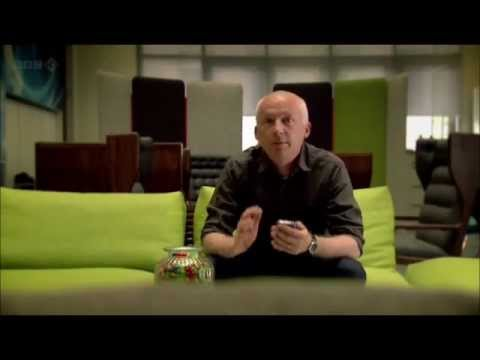

In [1]:
from IPython.display import YouTubeVideo

YouTubeVideo("iOucwX7Z1HU")

A idéia de ensemble gira em torno de ~ mais ou menos ~ isso :)

## Massa ! Mas comofas ):

Calma, jovem gafanhoto ! Existem vários métodos por trás de métodos de Ensemble e na aula de hoje vamos explorar alguns deles :)

# O Dataset

A ideia aqui, hoje, é focar na tecnica e deixar ela bem clara para vocês. Então, eu vou utilizar o dataset trabalhado na aula de regressão logística :)

## Relembrando

> The data is related with direct marketing campaigns of a Portuguese banking institution. The marketing campaigns were based on phone calls. Often, more than one contact to the same client was required, in order to access if the investment product would be or not subscribed.

Vamos dar uns 5 minutos para vocês relembrarem do dataset, darem uma explorada e aí a gente discute :)

In [2]:
import sys
sys.path.append('../code_utils/')

In [3]:
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot as plt
import pandas as pd
from plotting import (multiple_histograms_plot, plot_confusion_matrix,
                      plot_roc, predictions_hist)
import seaborn as sns

from sklearn.model_selection import train_test_split
from tqdm import tqdm_notebook

In [4]:
sns.set_context("notebook", font_scale=1.5)
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = 12, 6
df = pd.read_csv('../data/bank_marketing.csv')

Segue uma descrição sucinta de cada uma das colunas do dataset:

- `duration_seconds`: last contact duration, in seconds (numeric).

- `duration_minutes`: last contact duration, in minutes (numeric).

- `duration_hours`: last contact duration, in hours (numeric).

- `emp.var.rate`: employment variation rate - quarterly indicator (numeric)

- `nr.employed`: number of employees - quarterly indicator (numeric)

- `euribor3m`: euribor 3 month rate - daily indicator (numeric)

- `month`: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')

- `contact`: contact communication type (1 for cellular, 2 for telephone) 

- `loan`: has personal loan? (0 for no, 1 for yes)

- `subscribed` - has the client subscribed a term deposit? (True, False)

In [5]:
df.head()

,duration_seconds,duration_minutes,duration_hours,emp.var.rate,nr.employed,euribor3m,month,contact,loan,subscribed
0,261,4.350000,0.072500,1.1,5191.0,4.857,may,1,0,False
1,149,2.483333,0.041389,1.1,5191.0,4.857,may,1,0,False
2,226,3.766667,0.062778,1.1,5191.0,4.857,may,1,0,False
3,151,2.516667,0.041944,1.1,5191.0,4.857,may,1,0,False
4,307,5.116667,0.085278,1.1,5191.0,4.857,may,1,1,False


In [6]:
X = df.drop(['month', 'subscribed'], axis=1)
y = df[['subscribed']]

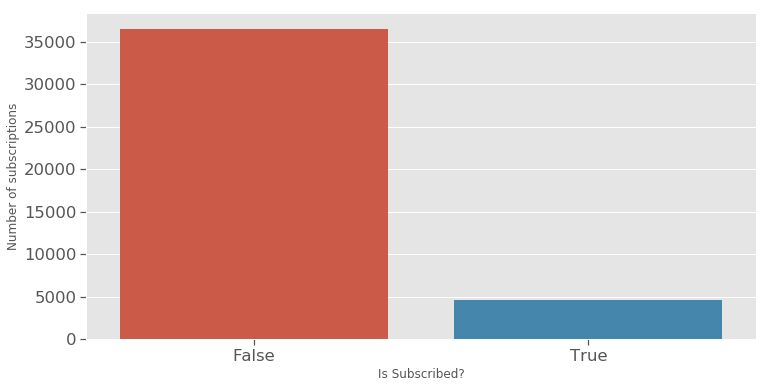

In [7]:
fig = sns.countplot(y['subscribed'])
fig.set(xlabel='Is Subscribed?', ylabel='Number of subscriptions')    
plt.show()

In [8]:
?? train_test_split

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2)

In [10]:
len(X_train), len(X_test)

(32947, 8237)

# Bootstraping

A ideia de bootstraping é um conceito relativamente simples: você tem uma amostra inicial de tamanho $N$. Podemos construir várias amostras de tamnho $X$, sendo $X$ menor que $N$ a partir dessa amostra inicial. A chance de um elemento ser escolhido é a mesma para qualquer ponto e pode haver repetição.

A gente pode repetir esse processo $Y$ vezes e, então obteremos $Y$ amostras e cada uma com tamanho $X$.

Não vou entrar muito em detalhe matemático (a referência estará no pós aula para quem quiser)

![title](../imgs/bootstraping.png)

In [11]:
#Taken from: https://mlcourse.ai/articles/topic5-part1-bagging/
import numpy as np

def get_bootstrap_samples(data, n_samples):
    """Generate bootstrap samples using the bootstrap method."""
    """Gera n_samples amostras aleatorias entre
    de 0 ao tamanho do df, todas de tamanho igual ao tamanho do df 
    """
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

def stat_intervals(stat, alpha):
    """Produce an interval estimate."""
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [12]:
# Save the data about the loyal and former customers to split the dataset
subscribed = df[df['subscribed'] == True]['duration_seconds'].values
not_subscribed = df[df['subscribed'] == False]['duration_seconds'].values

# Set the seed for reproducibility of the results
np.random.seed(0)

# Generate the samples using bootstrapping and calculate the mean for each of them
subs_mean_scores = [np.mean(sample) 
                       for sample in get_bootstrap_samples(subscribed, 1000)]
not_subs_mean_scores = [np.mean(sample) 
                       for sample in get_bootstrap_samples(not_subscribed, 1000)]

# Print the resulting interval estimates
print("Duration seconds from subscribed: mean interval", stat_intervals(subs_mean_scores, 0.05))
print("Duration seconds from not_subscribed: mean interval", stat_intervals(not_subs_mean_scores, 0.05))

Duration seconds from subscribed: mean interval [  819.26198276  2234.15881466]
Duration seconds from not_subscribed: mean interval [ 292.76269702  520.52512246]


In [13]:
len(subs_mean_scores)

1000

O que podemos ver aqui é que com 95% de probabilidade, o temo da ligação em segundos das pessoas que se increveram é entre $800$ e $2200$ e os não inscritos é de $293$ e $520$. Isso faz bastante sentido já que pessoas que não se inscreveram provavelmente se desinteressam  mais rápido

## Colocando Machine Learning

### Todos os dados

In [14]:
logreg = LogisticRegression(class_weight='balanced', random_state=42)

In [15]:
y_train.head()

,subscribed
9649,True
11206,False
13087,False
23856,False
9257,False


In [16]:
logreg.fit(X_train,y_train['subscribed'])

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=42,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [17]:
y_pred = logreg.predict_proba(X_test)[:, 1]

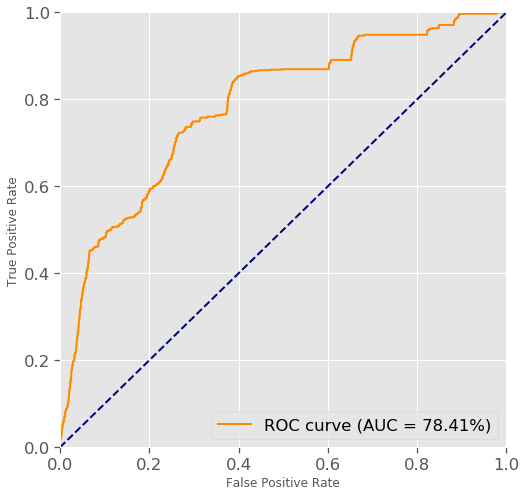

In [18]:
_ = plot_roc(y_test, y_pred)

## Amostra dos dados

In [19]:
def sample(x, y, f):
    sx = x.sample(frac=f)
    sy = y.loc[sx.index]
    return sx, sy

In [20]:
predictions = []
for r in tqdm_notebook(range(500)):
    """fazemos uma amostra com metade dos dados
    """
    sx, sy = sample(X_train, y_train['subscribed'], 0.5)
    logreg.fit(sx, sy)
    ypred = logreg.predict_proba(X_test)[:, 1]
    predictions.append(ypred)

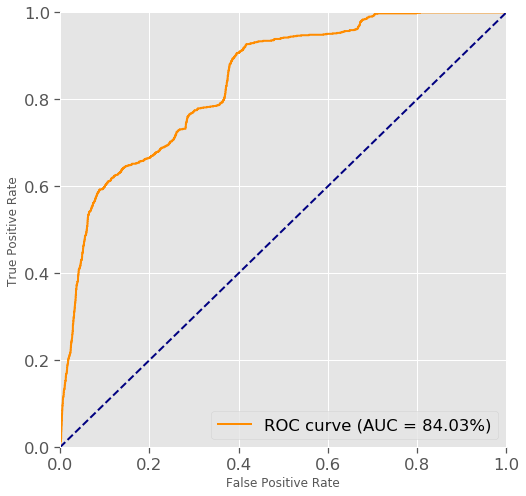

In [21]:
#ensemble !
mean_preds = np.mean(np.array(predictions), axis=0)
_ = plot_roc(y_test, mean_preds)

<img src="https://media.giphy.com/media/mIZr3jYOo0MbzPeqeN/giphy.gif" width="300">


Legal, né? :)

O que acabamos de ver é uma combinação de algoritmos, ou ensemble, mais especificamente o Bagging !

# Bagging

Extendendo um pouco a ideia, podemos definir o Bagging como a ideia de que aplicamos bootstraping em cima dos nossos dados e para **cada** amostra de dados, podemos treinar um classificador **diferente** e, em cima dos resultados, calculamos uma média deles.

![](../imgs/bagging.png)
[Source](https://mlcourse.ai/articles/topic5-part1-bagging/#3.-Bagging)

A ideia é que ao fazermos o bagging, nós estamos reduzindo a **variância** do nosso modelo e, consequentemente, evitando **overfitting**. Em outras palavras, modelos de bagging são **robustos** a **overfitting**

In [22]:
from sklearn.ensemble import BaggingClassifier, BaggingRegressor
# Bagging with a logistic regression classifier
bdt = BaggingClassifier(logreg, random_state=42).fit(X_train, y_train['subscribed'])
bdt_predict = bdt.predict_proba(X_test)[:,1]

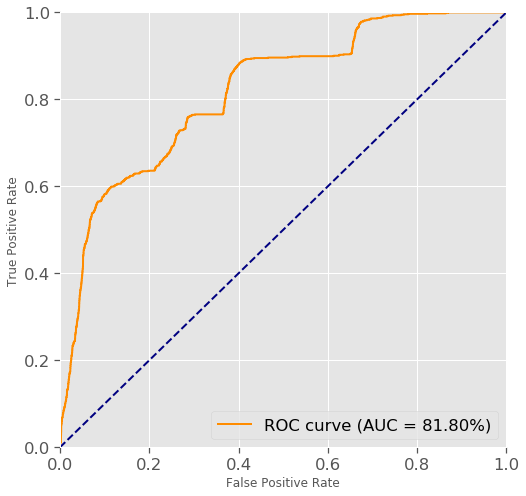

In [23]:
#ensemble !
_ = plot_roc(y_test, bdt_predict)

## Random Forest

Random Forest é um dos algoritmos mais clássicos de Bagging :) Mas para entendermos ela, vamos dar uma revisada rápida

### Relembrando Decision Trees

Eu esqueci ): Me ajudem a lembrar !

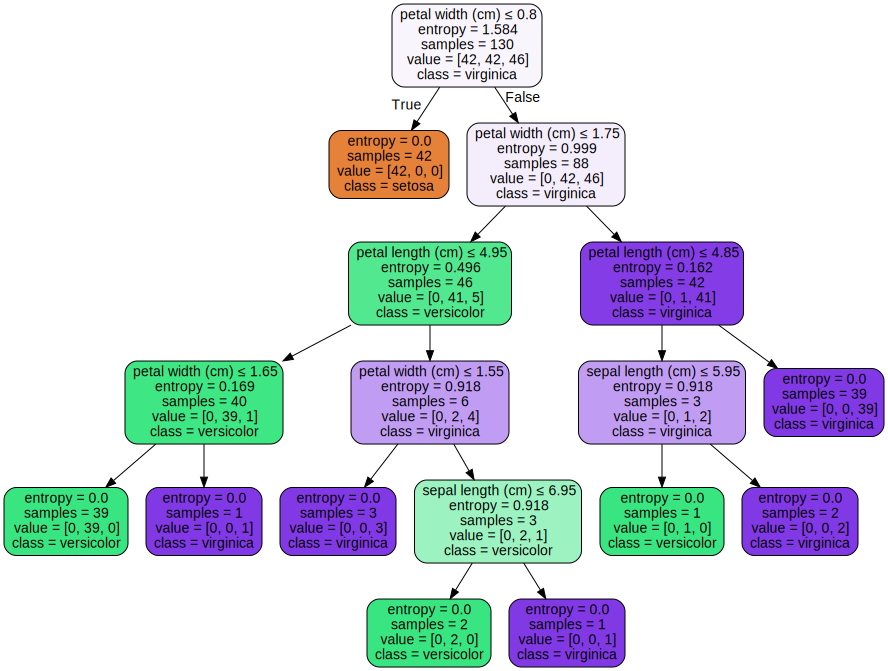

In [24]:
import pandas as pd
from sklearn import datasets
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
import graphviz


def accuracy(yt, yp):
    return (yp==yt).mean()


# Carregando os dados
iris = datasets.load_iris()

x = pd.DataFrame(iris.data, columns=iris.feature_names)
y = pd.Series(iris.target)

xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=20, random_state=1)


dt = DecisionTreeClassifier(criterion='entropy', random_state=1)
dt.fit(xtrain, ytrain)

ypred = dt.predict(xtest)



accuracy(ytest, ypred)


dot_data = tree.export_graphviz(dt, out_file=None, 
                     feature_names=iris.feature_names,  
                     class_names=iris.target_names,  
                     filled=True, rounded=True,  
                     special_characters=True)
graph = graphviz.Source(dot_data)  
graph

## Comparando Random Forests e Decision Trees

Random Forests nada são que Bagging de Decision Trees, com a diferença que a cada "rodada" de bagging, um subset de features também é selecionado aleatoriamente.

Vamos comparar eles?

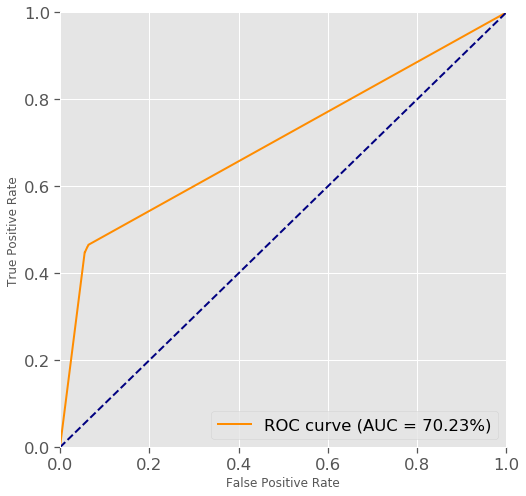

In [25]:
dt = tree.DecisionTreeClassifier(class_weight='balanced', random_state=42).fit(X_train, y_train['subscribed'])
dt_predict = dt.predict_proba(X_test)[:,1]
_ = plot_roc(y_test, dt_predict)

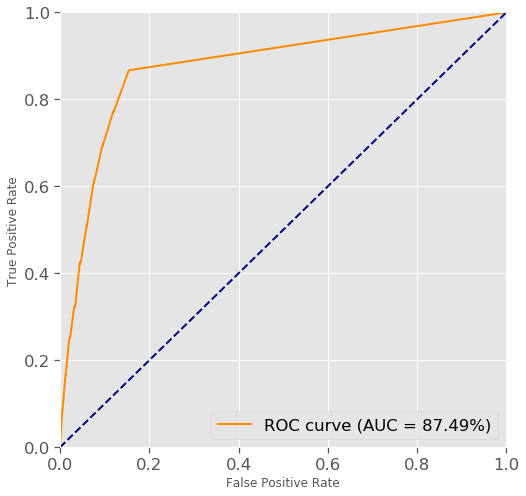

In [26]:
bdt = BaggingClassifier(dt, random_state=42, n_estimators=10).fit(X_train, y_train['subscribed'])
bdt_predict = bdt.predict_proba(X_test)[:,1]
_ = plot_roc(y_test, bdt_predict)

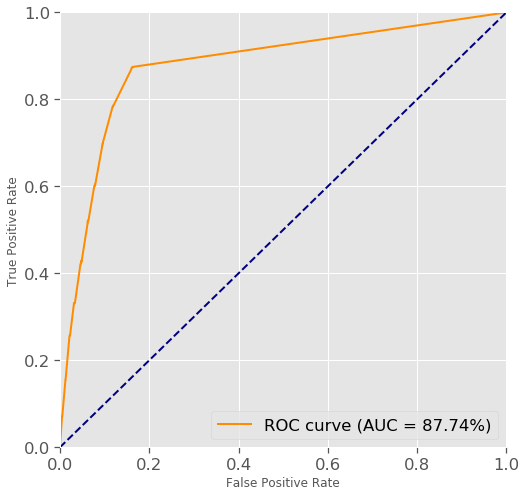

In [27]:
from sklearn.ensemble import RandomForestClassifier

rf = (RandomForestClassifier(n_estimators=10,
                             random_state=42,  
                             class_weight='balanced')
      .fit(X_train, y_train['subscribed'])
     )
rf_predict = rf.predict_proba(X_test)[:,1]
_ = plot_roc(y_test, rf_predict)

Resultados extremamente parecidos, e os dois foram extremamente melhor que a nossa antiga regressão logística (e decision tree) ! 

Isso explica pq RF foi um dos algoritmos mais poderosos por tanto tempo :)

### Vantagens e desvantagens das RF

[link](https://mlcourse.ai/articles/topic5-part2-rf/#9.-Pros-and-cons-of-random-forests)

# Voting

Vimos um exemplo de um método de Ensemble que combina vários modelos iguais, mas e se esses modelos forem diferentes?

Temos o VotingClassifier pra isso !

Ele é bem direto ao ponto: você treina vários, e o voto da maioria dos classificadores vira a classe final

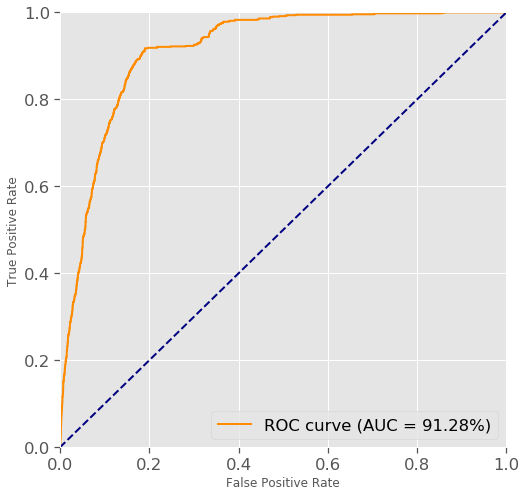

In [28]:
from sklearn.ensemble import VotingClassifier

dt1 = DecisionTreeClassifier(random_state=1, class_weight='balanced')
dt2 = DecisionTreeClassifier(max_depth=12, max_features=5, random_state=42, class_weight='balanced')
lr1 = LogisticRegression(class_weight='balanced')
lr2 = LogisticRegression(C=0.001, penalty='l1', class_weight='balanced')
rf = RandomForestClassifier(class_weight='balanced', random_state=42)


clfs = [('dt1', dt1),
        ('dt2', dt2),
        ('lr1', lr1),
        ('lr2', lr2),
        ('rf', rf)
       ]

vot = VotingClassifier(clfs, voting='soft')
vot.fit(X_train, y_train['subscribed'])

vot_predict = vot.predict_proba(X_test)[:,1]
_ = plot_roc(y_test, vot_predict)

## Weight

Podemos ponderar os nossos classificadores se acharmos que uns se saem melhor que outros

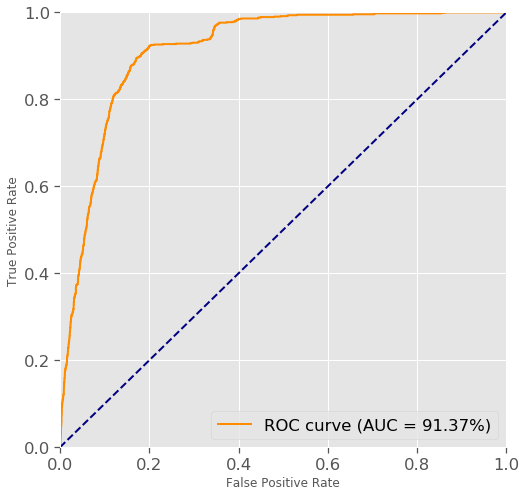

In [29]:
dt1 = DecisionTreeClassifier(random_state=1, class_weight='balanced')
dt2 = DecisionTreeClassifier(max_depth=12, max_features=5, random_state=42, class_weight='balanced')
lr1 = LogisticRegression(class_weight='balanced')
lr2 = LogisticRegression(C=0.001, penalty='l1', class_weight='balanced')
rf = RandomForestClassifier(class_weight='balanced', random_state=42)


clfs = [('dt1', dt1),
        ('dt2', dt2),
        ('lr1', lr1),
        ('lr2', lr2),
        ('rf', rf)
       ]

vot = VotingClassifier(clfs, voting='soft', weights=[3,1,1,3,10])
vot.fit(X_train, y_train['subscribed'])

vot_predict = vot.predict_proba(X_test)[:,1]
_ = plot_roc(y_test, vot_predict)

# Stacking

Esse é o grande secret sauce para ganhr competições do Kaggle. É um dos ensembles mais "avançados" e geralmente a trackeabilidade dele é raramente colocada em prática

> This is a truly impressive compilation and culmination of years of work, blending hundreds of predictive models to finally cross the finish line. We evaluated some of the new methods offline but the additional accuracy gains that we measured did not seem to justify the engineering effort needed to bring them into a production environment. **Netflix Engineers** about Netflix Challenge

A ideia é simples: combinar o **resultado** de multiplos modelos e usar essa informação para gera um modelo novo :)

In [30]:
X_base, X_meta, y_base, y_meta = train_test_split(X_train, y_train['subscribed'], test_size=0.5, random_state=42)

In [31]:
rf = RandomForestClassifier(random_state=42,class_weight='balanced')
lr = LogisticRegression(random_state=42, class_weight='balanced')
dt = DecisionTreeClassifier(random_state=42, class_weight='balanced')

In [32]:
rf.fit(X_base,y_base)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=42,
            verbose=0, warm_start=False)

In [33]:
lr.fit(X_base,y_base)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=42,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [34]:
dt.fit(X_base,y_base)

DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best')

In [35]:
rf_preds = pd.DataFrame(rf.predict_proba(X_meta),
                   columns=['rf_prob_1', 'rf_prob_2'],
                   index=X_meta.index
                  )

In [36]:
lr_preds = pd.DataFrame(lr.predict_proba(X_meta),
                   columns=['lr_prob_1', 'lr_prob_2'],
                   index=X_meta.index
                  )

In [37]:
dt_preds = pd.DataFrame(dt.predict_proba(X_meta),
                   columns=['dt_prob_1', 'dt_prob_2'],
                   index=X_meta.index
                  )

In [38]:
meta = X_meta.join(rf_preds).join(lr_preds).join(dt_preds)

In [39]:
log = LogisticRegression(class_weight='balanced')

In [40]:
log.fit(meta,y_meta)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [41]:
rf_preds = pd.DataFrame(rf.predict_proba(X_test),
                   columns=['rf_prob_1', 'rf_prob_2'],
                   index=X_test.index
                  )

In [42]:
lr_preds = pd.DataFrame(lr.predict_proba(X_test),
                   columns=['lr_prob_1', 'lr_prob_2'],
                   index=X_test.index
                  )

In [43]:
dt_preds = pd.DataFrame(dt.predict_proba(X_test),
                   columns=['dt_prob_1', 'dt_prob_2'],
                   index=X_test.index
                  )

In [44]:
meta_test = X_test.join(rf_preds).join(lr_preds).join(dt_preds)

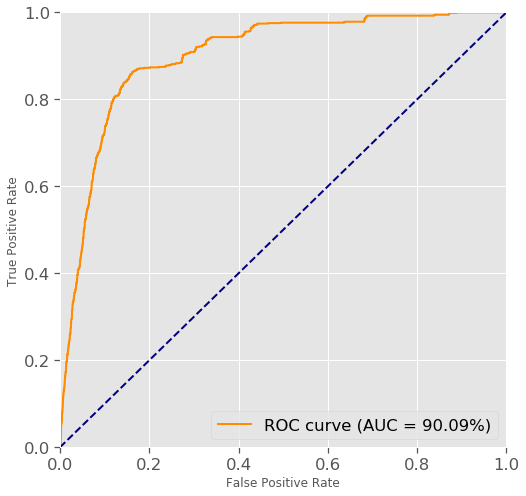

In [45]:
log_predict = log.predict_proba(meta_test)[:,1]
_ = plot_roc(y_test, log_predict)

# There is No Free Lunch

> There is no best algorithm that universally solves any problem in machine learning. 

# You did it !

<img src="https://media.giphy.com/media/3ohzdIuqJoo8QdKlnW/giphy.gif" width="600">

Na aula de hoje vocês aprendeream como usar ensembles e os diferentes métodos existentes :)